In [1]:
from scraper import Scraper as BoxscoreScraper

In [2]:
scraper = BoxscoreScraper(year=2023)

In [3]:
scraper.get_season_boxscores()

Beginning scraping for 2023-2024 season



  0%|          | 0/2 [00:00<?, ?it/s]

Scraping boxscores for Week 1
Succesfully scraped boxscores for Week 1

Scraping boxscores for Week 2
Succesfully scraped boxscores for Week 2



In [36]:
from filing import Filing

import pandas as pd
class Cleaning:

    def __init__(self, **kwargs):
        """
        This class will contain the functionality to combine, clean, wrangle, and partition all the boxscores
        """

        self.year: int = int(kwargs.get('year', 2023))
        self.season: str = f'{self.year}-{self.year+1}'

        # Initialize filing object
        self.filing = Filing(self.season)

        # ppr_coeff = 0.5 if kwargs.get('hppr', False) else 1.0      
        self.raw: pd.DataFrame = (self.filing.combined()
                                  # .assign(fpts=lambda df: 0.04*df.pass_yds + 4.0*df.pass_td - 1.0*df.pass_int + 0.1*df.rush_yds + 6.0*df.rush_td + ppr_coeff*df.rec + 0.1*df.rec_yds + 6.0*df.rec_td - 1.0*df.fumbles_lost)
                                 )
        self.positions: pd.DataFrame = self.filing.positions()



In [37]:
cleaning = Cleaning(year=2022)

In [38]:
df = cleaning.raw

In [39]:
df['game-id'] = df[['team', 'opp', 'week']].apply(lambda row: f'{row.iloc[0]}-{row.iloc[1]}-week{row.iloc[2]}' if row.iloc[0] > row.iloc[1] else f'{row.iloc[1]}-{row.iloc[0]}-week{row.iloc[2]}', axis=1)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6997 entries, 0 to 6996
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             6997 non-null   object 
 1   team             6997 non-null   object 
 2   pass_cmp         6997 non-null   float64
 3   pass_att         6997 non-null   float64
 4   pass_yds         6997 non-null   float64
 5   pass_td          6997 non-null   float64
 6   pass_int         6997 non-null   float64
 7   pass_sacked      6997 non-null   float64
 8   pass_sacked_yds  6997 non-null   float64
 9   pass_long        6997 non-null   float64
 10  pass_rating      6997 non-null   float64
 11  rush_att         6997 non-null   float64
 12  rush_yds         6997 non-null   float64
 13  rush_td          6997 non-null   float64
 14  rush_long        6997 non-null   float64
 15  targets          6997 non-null   float64
 16  rec              6997 non-null   float64
 17  rec_yds       

In [41]:
games_df: pd.DataFrame = (df
                          .drop_duplicates('game-id')
                          .loc[:, ['week', 'team', 'opp', 'home', 'score', 'opp_score', 'spread', 'total']]
                          .reset_index(drop=True)
                         )
print(f'Total games: {games_df.shape[0]}')

Total games: 271


In [42]:
n_bins = 15

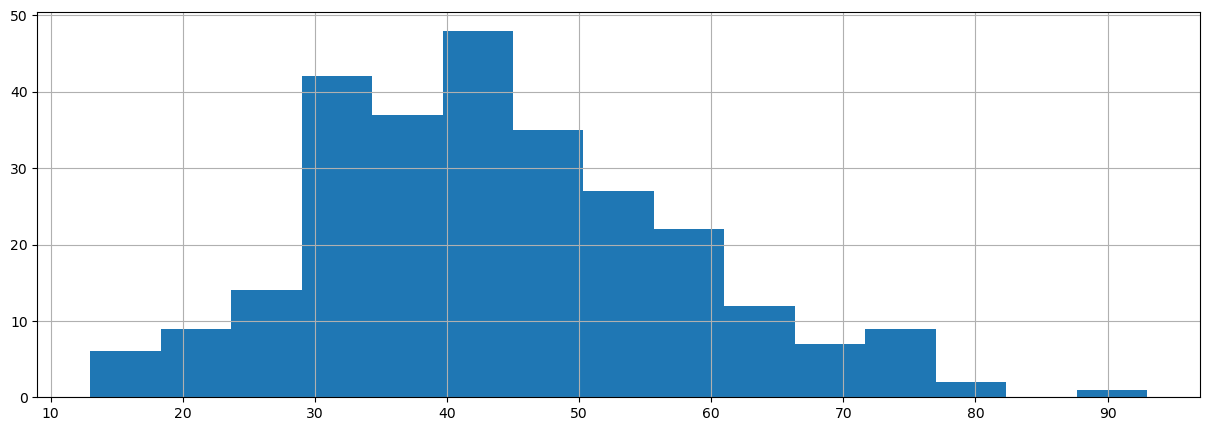

In [43]:
(games_df
 ['total']
 .hist(figsize=(15,5), bins=n_bins)
);

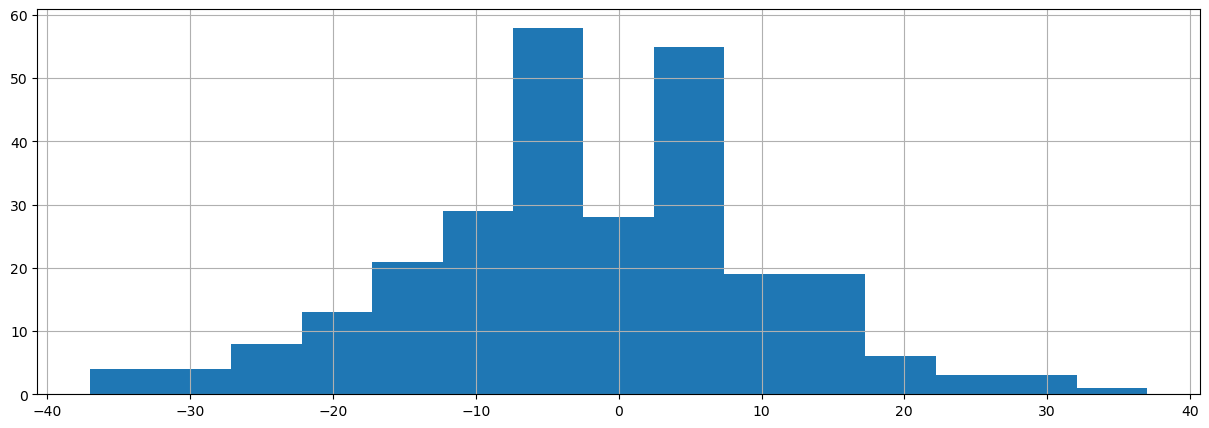

In [44]:
(games_df
 ['spread']
 .hist(figsize=(15,5), bins=n_bins)
);

In [45]:
# Need to figure out how to classify position depth --> May run into issues with injuries

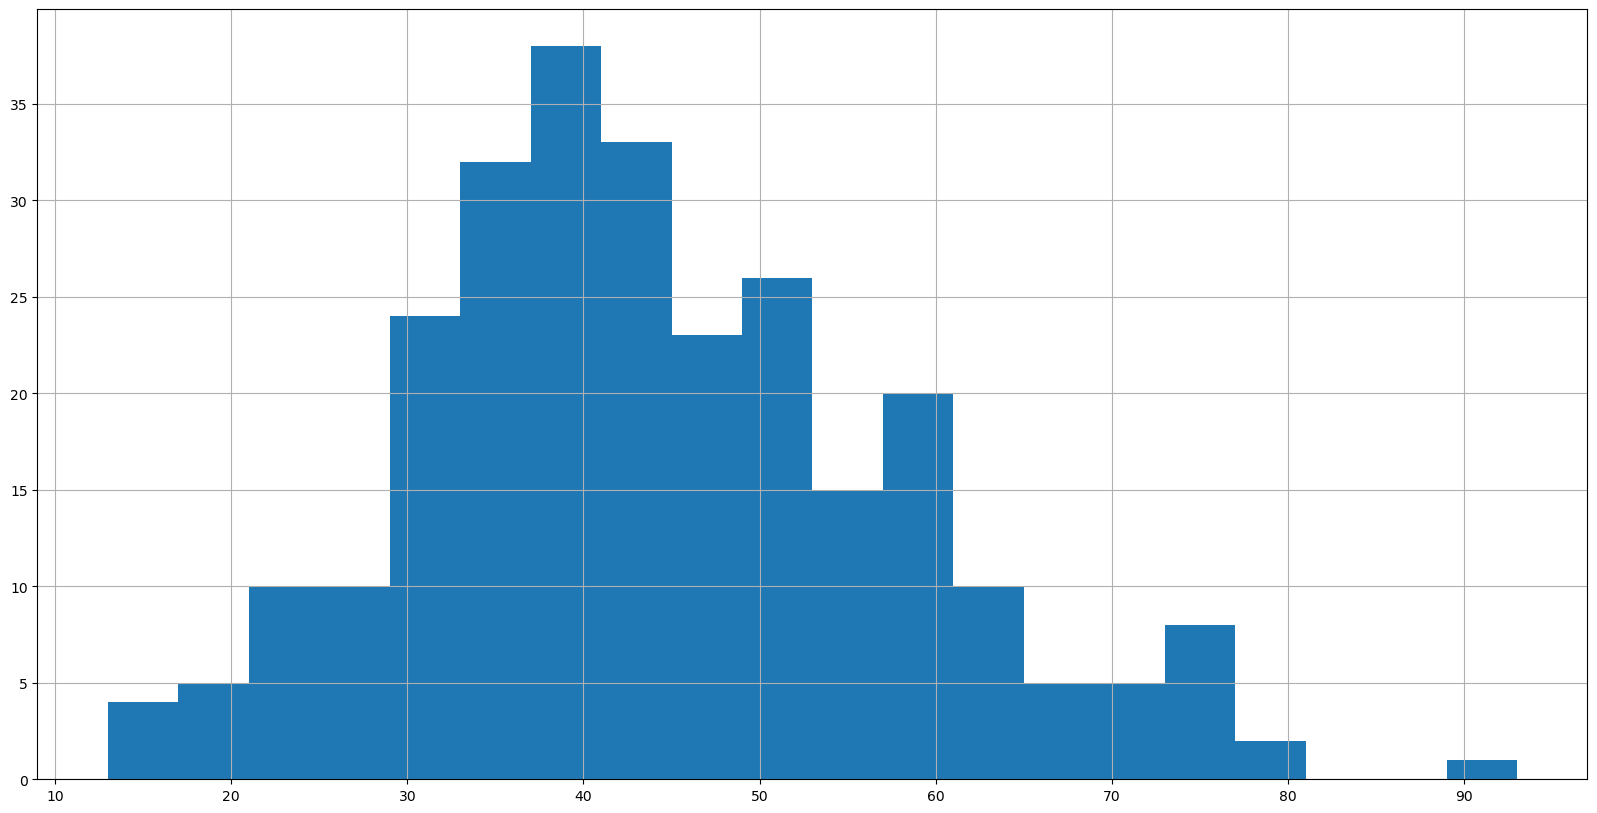

In [46]:
(df
 .drop_duplicates('game-id')
 ['total']
 .hist(figsize=(20,10), bins=20)
);

In [47]:
import numpy as np
import scipy.stats as stats

import itertools

In [60]:

team_cores = {
    'CLE': [
        'Nick Chubb',
        'Amari Cooper',
        'David Njoku',
        'Cade York',
        'Browns'
        
    ],

    'PIT': [
        'Kenny Pickett',
        'George Pickens',
        'Pat Freiermuth',
        'Najee Harris',
        'Chris Boswell',
        'Steelers'

    ]
}
team_dfs = {
    team: df.loc[(df['team'] == team) & (df['name'].isin(core)) & (df['fpts'] > 0.0)] 
    for team, core in team_cores.items()
}

In [61]:
# Get the games core players have played in together
# Example: If AJ Brown is missing, DeVonta Smith might have a much better game than usual and will skew results OR
# he might have a much worse game since a better corner is most likely guarding him
team_core_together_weeks = {
    team: tuple(team_df
                .groupby('week')
                ['week']
                .agg(['count'])
                .pipe(lambda df_: df_.loc[df_['count'] == len(team_cores[team])])
                .index
               )
    for team, team_df in team_dfs.items()
}

In [62]:
team_core_fpts = {
    team: {
        name: [ (team_df.loc[(team_df['name'] == name) & (team_df['week'] == week ), 'fpts'].item()) for week in team_core_together_weeks[team] ]
        for name in team_cores[team]
    }

    for team, team_df in team_dfs.items()
}

In [63]:
agg_stats = ['mean']

In [64]:
team_combo_corrs = {
    team: dict(sorted({
        combo: round(stats.pearsonr(core_fpts[combo[0]], core_fpts[combo[1]])[0],3)
        for combo in itertools.combinations(team_cores[team], 2)
    }.items(), key=lambda item: item[1], reverse=True))
    for team, core_fpts in team_core_fpts.items()
}

In [65]:
team_combo_corrs['CLE']

{('Cade York', 'Browns'): 0.17,
 ('Amari Cooper', 'Browns'): 0.147,
 ('Nick Chubb', 'David Njoku'): 0.143,
 ('David Njoku', 'Browns'): 0.082,
 ('Nick Chubb', 'Amari Cooper'): 0.04,
 ('Nick Chubb', 'Cade York'): -0.006,
 ('Amari Cooper', 'David Njoku'): -0.153,
 ('Nick Chubb', 'Browns'): -0.294,
 ('Amari Cooper', 'Cade York'): -0.299,
 ('David Njoku', 'Cade York'): -0.399}

In [66]:
team_combo_corrs['PIT']

{('George Pickens', 'Pat Freiermuth'): 0.957,
 ('Kenny Pickett', 'Chris Boswell'): 0.632,
 ('Chris Boswell', 'Steelers'): 0.53,
 ('Kenny Pickett', 'George Pickens'): 0.474,
 ('Najee Harris', 'Steelers'): 0.458,
 ('Najee Harris', 'Chris Boswell'): 0.389,
 ('Kenny Pickett', 'Pat Freiermuth'): 0.313,
 ('Kenny Pickett', 'Steelers'): 0.308,
 ('George Pickens', 'Steelers'): -0.039,
 ('Kenny Pickett', 'Najee Harris'): -0.212,
 ('Pat Freiermuth', 'Steelers'): -0.228,
 ('George Pickens', 'Chris Boswell'): -0.344,
 ('Pat Freiermuth', 'Chris Boswell'): -0.467,
 ('George Pickens', 'Najee Harris'): -0.742,
 ('Pat Freiermuth', 'Najee Harris'): -0.894}

In [67]:
agg_stats = ['rush_yds', 'rush_td', 'rec_yds', 'rec_td']
teams = ['PIT', 'CLE']

In [68]:
agg_df = (df
          .groupby('opp')
          [agg_stats]
          .agg(['sum'])
          .reset_index()
          .set_axis(['opp'] + agg_stats, axis=1)
          .pipe(lambda df_: df_.loc[df_['opp'].isin(teams)])
          .set_index('opp')
          .assign(
              total_yds=lambda df_: df_.rush_yds + df_.rec_yds,
              total_td=lambda df_: df_.rush_td + df_.rec_td 
          )
         )
agg_df

,rush_yds,rush_td,rec_yds,rec_td,total_yds,total_td
opp,,,,,,
CLE,2295.0,22.0,3547.0,20.0,5842.0,42.0
PIT,1838.0,7.0,4066.0,29.0,5904.0,36.0


In [69]:
# agg_df.sort_values([
#     'fpts',
#     # 'total_td',
#     # 'total_yds',
#     'rec',
#     # 'rush_td',
#     'rush_yds',
# ], ascending=False)